In [1]:
import gdown
# https://drive.google.com/file/d/10x-39P6o6QA9-BVnlnxDVib23rbMlHGL/view?usp=drive_link
file_id = "10x-39P6o6QA9-BVnlnxDVib23rbMlHGL"  # replace with actual file ID
output = "LCData.zip"

!gdown --id {file_id} -O {output}
!unzip -q {output} -d ./LCData

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=10x-39P6o6QA9-BVnlnxDVib23rbMlHGL
From (redirected): https://drive.google.com/uc?id=10x-39P6o6QA9-BVnlnxDVib23rbMlHGL&confirm=t&uuid=8f9eb4ee-4750-432f-83f6-af923c81338f
To: /content/LCData.zip
100% 2.43G/2.43G [00:36<00:00, 66.1MB/s]


In [2]:
!pip install segmentation-models  -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00


In [3]:

#import Necessary Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet
import keras
keras.backend.set_image_data_format("channels_last")

Segmentation Models: using `tf.keras` framework.


In [4]:
data_dir = "/content/LCData/Val/Urban"  # path to LoveDA validation set
image_dir = os.path.join(data_dir, "images_png")
mask_dir = os.path.join(data_dir, "masks_png")

X, y = [], []

In [19]:
# Select subset of images to keep runtime reasonable
max_images = 900
target_size = (128, 128)

images = []
masks = []

for i, fname in enumerate(os.listdir(image_dir)):
    if not fname.endswith(".png"):
        continue
    if i >= max_images:
        break
    img = imread(os.path.join(image_dir, fname))
    mask = imread(os.path.join(mask_dir, fname))

    img_resized = resize(img, target_size, anti_aliasing=True, preserve_range=True).astype(np.uint8)
    mask_resized = resize(mask, target_size, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

    images.append(img_resized)
    masks.append(mask_resized)

images = np.array(images)   # shape (N,H,W,3)
masks = np.array(masks)     # shape (N,H,W)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Images shape: (677, 128, 128, 3)
Masks shape: (677, 128, 128)


In [21]:

# --- 3. Preprocess ---
# Normalize images
images = images

num_classes = 8
# Convert masks to categorical one-hot
masks_cat = to_categorical(masks, num_classes=num_classes)  # shape (N,H,W,C)

# Split train/test/val
X_train, X_temp, y_train, y_temp = train_test_split(images, masks_cat, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training shape:", X_train.shape, y_train.shape)



Training shape: (473, 128, 128, 3) (473, 128, 128, 8)


In [22]:

# --- 4. Define U-Net model ---
model = Unet(
    backbone_name="resnet18",
    classes=8,
    activation="sigmoid",
    encoder_weights=None,
    input_shape=(128, 128, 3),
)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_72   │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │      9,408 │ zero_padding2d_7… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_73   │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_74   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_7… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_75   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_7… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 14,341,585 (54.71 MB)

 Trainable params: 14,331,659 (54.67 MB)

 Non-trainable params: 9,926 (38.77 KB)

In [23]:

# --- 5. Train ---
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=8,
                    epochs=20)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 53s 451ms/step - accuracy: 0.2967 - loss: 1.8261 - val_accuracy: 0.1540 - val_loss: 769.9062
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.4842 - loss: 1.3521 - val_accuracy: 0.1232 - val_loss: 72.4104
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.5107 - loss: 1.2851 - val_accuracy: 0.4475 - val_loss: 1.7003
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5218 - loss: 1.2399 - val_accuracy: 0.4728 - val_loss: 1.6104
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5299 - loss: 1.2370 - val_accuracy: 0.5526 - val_loss: 1.1733
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5423 - loss: 1.1856 - val_accuracy: 0.4830 - val_loss: 1.4755
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5290 - loss: 1.2449 - val_accuracy: 0.5648 - val_loss: 1.1363
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5594 - loss: 1.1664 - val_accuracy: 0.539

In [24]:
# --- 6. Evaluate ---
loss, acc = model.evaluate(X_test, y_test)
print(f"Test pixel-wise accuracy: {acc:.3f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6430 - loss: 0.9592
Test pixel-wise accuracy: 0.646


In [25]:
img

array([[[172, 162, 156],
        [174, 164, 157],
        [174, 165, 157],
        ...,
        [ 82,  84,  83],
        [ 82,  84,  83],
        [ 80,  81,  82]],

       [[180, 170, 166],
        [181, 170, 167],
        [180, 169, 167],
        ...,
        [ 83,  85,  83],
        [ 81,  84,  82],
        [ 82,  83,  83]],

       [[183, 171, 174],
        [181, 168, 166],
        [180, 167, 160],
        ...,
        [ 83,  84,  83],
        [ 81,  84,  83],
        [ 83,  85,  83]],

       ...,

       [[ 68,  66,  66],
        [ 90,  93,  94],
        [ 74,  83,  78],
        ...,
        [ 86,  98,  89],
        [ 88,  99,  90],
        [ 86,  94,  82]],

       [[ 74,  74,  76],
        [ 81,  87,  83],
        [ 67,  77,  70],
        ...,
        [ 74,  85,  86],
        [ 74,  83,  78],
        [ 85,  92,  83]],

       [[ 76,  80,  78],
        [ 75,  84,  79],
        [ 62,  73,  59],
        ...,
        [ 64,  71,  67],
        [ 70,  76,  79],
        [ 78,  84,  86]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


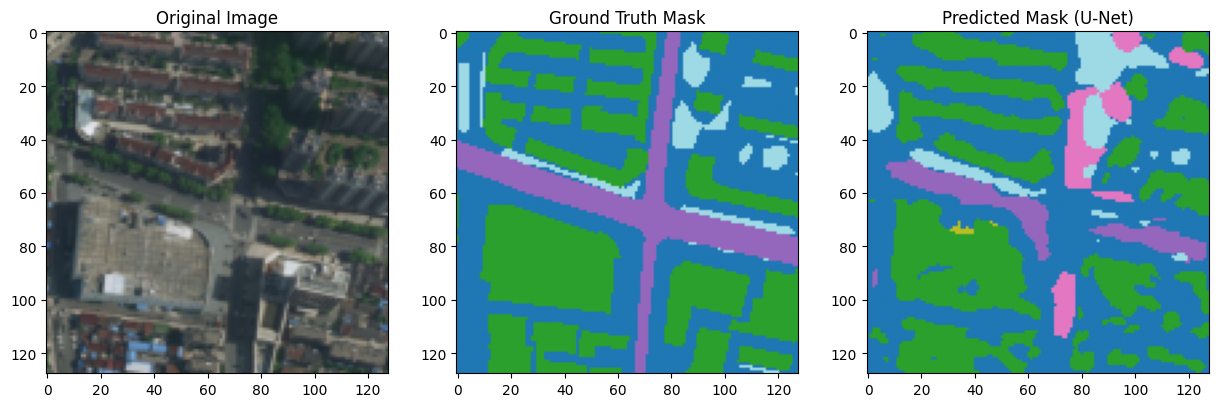

In [27]:

# --- 7. Predict and visualize ---
idx = 30  # pick first test image
img = X_test[idx]
mask_true = np.argmax(y_test[idx], axis=-1)

pred_probs = model.predict(img[None, ...])
mask_pred = np.argmax(pred_probs[0], axis=-1)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(mask_true, cmap='tab20')
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(mask_pred, cmap='tab20')
plt.title("Predicted Mask (U-Net)")

plt.show()


In [ ]:

# --- 8. Pixel-wise metrics ---
y_test_flat = np.argmax(y_test.reshape(-1, num_classes), axis=-1)
y_pred_flat = np.argmax(model.predict(X_test).reshape(-1, num_classes), axis=-1)

print("Pixel-wise Accuracy:", accuracy_score(y_test_flat, y_pred_flat))
print("\nClassification Report:\n", classification_report(y_test_flat, y_pred_flat))
cm = confusion_matrix(y_test_flat, y_pred_flat)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()